<a href="https://colab.research.google.com/github/RoyTng/ADALL-Project/blob/main/My_ADALL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Config File Readme

from google.colab import drive
drive.mount('/content/drive')  # authorise when prompted

BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/ADALL Project"

DATA_CSV  = f"{BASE_DIR}/Data/Ai4i.csv"

OUT_DIR   = f"{BASE_DIR}/Outputs"
MODEL_DIR = f"{BASE_DIR}/Models"

random_state = 42
target_col = "Machine failure"

drop_cols = [
    "UDI", "Product ID",          # identifiers (leakage risk)
    "TWF", "HDF", "PWF", "OSF", "RNF"  # failure modes (leakage vs target)
]

## <font color=red>**Upload Library**

In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os
# Visualisation
import matplotlib.pyplot as plt
# Modelling and preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix
)
import xgboost as xgb


from google.colab import drive
drive.mount('/content/drive')

# DATA_CSV = "/content/drive/MyDrive/Colab Notebooks/ADALL Project/Data/Ai4i.csv"
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/ADALL Project"
DATA_CSV = f"{BASE_DIR}/Data/Ai4i.csv"
OUT_DIR  = f"{BASE_DIR}/Outputs"
MODEL_DIR = f"{BASE_DIR}/Models"

os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

random_state = 42
target_col = "Machine failure"

df = pd.read_csv(DATA_CSV)
print("Raw shape:", df.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Raw shape: (10000, 14)


**No need to run the code below**

In [ ]:
# ====================
# Dataset Google Drive
# ====================
# df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ADALL Project/Data/Ai4i.csv")

# ====================
# Dataset GitHub
# ====================
# Example: Replace this with the raw URL of your GitHub file
# github_raw_url = 'https://raw.githubusercontent.com/RoyTng/ADALL-Project/refs/heads/main/Ai4i.csv'

try:
    df = pd.read_csv(github_raw_url)
    print("Successfully loaded data from GitHub!")
    display(df.head())
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please ensure the URL is correct and the file format is compatible with `pd.read_csv`.")


Successfully loaded data from GitHub!


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

### API Link to ChatGPT

In [ ]:
from google.colab import userdata
from openai import OpenAI

# Load key from Google Colab Secrets
api_key = userdata.get('OPENAI_API_KEY')

client = OpenAI(
    api_key=api_key,
)

In [ ]:
#generate a preview of ten rows as text first, so that we can use it for sending to LLM API later.
data_preview = df.head(10).to_string()
print(data_preview)

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  HDF  PWF  OSF  RNF
0    1     M14860    M                298.1                    308.6                    1551         42.8                0                0    0    0    0    0    0
1    2     L47181    L                298.2                    308.7                    1408         46.3                3                0    0    0    0    0    0
2    3     L47182    L                298.1                    308.5                    1498         49.4                5                0    0    0    0    0    0
3    4     L47183    L                298.2                    308.6                    1433         39.5                7                0    0    0    0    0    0
4    5     L47184    L                298.2                    308.7                    1408         40.0                9                0    0    0    0    0    0
5    6    

### Data Profiling

In [ ]:
import pandas as pd
import numpy as np
from io import StringIO

# ---------------------------
# Generate a full dataset profile
# ---------------------------

buffer = StringIO()

# dtypes
buffer.write("=== DTYPES ===\n")
buffer.write(df.dtypes.to_string())
buffer.write("\n\n")

# numeric describe
buffer.write("=== NUMERIC DESCRIBE ===\n")
buffer.write(df.describe().to_string())
buffer.write("\n\n")

# categorical describe
buffer.write("=== CATEGORICAL DESCRIBE ===\n")
try:
    buffer.write(df.describe(include='object').to_string())
except:
    buffer.write("No categorical columns")
buffer.write("\n\n")

# null summary
buffer.write("=== NULL SUMMARY ===\n")
null_summary = (
    df.isna().sum().to_frame("null_count")
    .assign(null_pct=lambda x: x["null_count"]/len(df))
)
buffer.write(null_summary.to_string())
buffer.write("\n\n")

# unique cardinality
buffer.write("=== UNIQUE VALUES PER COLUMN ===\n")
buffer.write(df.nunique().to_frame("unique_count").to_string())
buffer.write("\n\n")

# correlation matrix
buffer.write("=== CORRELATIONS (NUMERIC ONLY) ===\n")
buffer.write(df.corr(numeric_only=True).round(3).to_string())
buffer.write("\n\n")

# value counts for categoricals
buffer.write("=== VALUE COUNTS (TOP 20 PER CATEGORICAL COLUMN) ===\n")
cat_cols = df.select_dtypes(include='object').columns
if len(cat_cols) > 0:
    for col in cat_cols:
        buffer.write(f"\nColumn: {col}\n")
        vc = df[col].value_counts().head(20)
        buffer.write(vc.to_string())
        buffer.write("\n")
else:
    buffer.write("No categorical columns\n")
buffer.write("\n")

# --------- FIXED OUTLIER COMPUTATION (NO BOOLEANS) ---------
buffer.write("=== OUTLIER SUMMARY (IQR METHOD) ===\n")
num_cols = df.select_dtypes(include=['number']).columns  # exclude booleans
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df[num_cols] < (Q1 - 1.5*IQR)) | (df[num_cols] > (Q3 + 1.5*IQR))).sum()
buffer.write(outliers.to_string())
buffer.write("\n\n")

# leakage scan: columns with all unique values
buffer.write("=== POSSIBLE LEAKAGE COLUMNS (UNIQUE FOR EACH ROW) ===\n")
leak_cols = df.columns[df.nunique() == len(df)]
buffer.write(str(list(leak_cols)))
buffer.write("\n\n")

# shape, duplicates, constant cols
buffer.write("=== SHAPE / DUPLICATES / CONSTANT COLUMNS ===\n")
dup_count = df.duplicated().sum()
constant_cols = df.columns[df.nunique() == 1].tolist()
buffer.write(f"Rows: {len(df)}, Columns: {df.shape[1]}\n")
buffer.write(f"Duplicate rows: {dup_count}\n")
buffer.write(f"Constant columns: {constant_cols}\n\n")

# Final text
payload_text = buffer.getvalue()

print(payload_text)


=== DTYPES ===
UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64

=== NUMERIC DESCRIBE ===
               UDI  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]   Torque [Nm]  Tool wear [min]  Machine failure           TWF           HDF           PWF           OSF          RNF
count  10000.00000         10000.000000             10000.000000            10000.000000  10000.000000     10000.000000     10000.000000  10000.000000  10000.000000  10000.000000  10000.000000  10000.00000
mean    5000.50000           300.004930               310

### LLM-assisted Data Profiling

In [ ]:
response = client.responses.create(
    model="gpt-5-mini",
    instructions="""
You are an expert data scientist with extensive knowledge of tree-based models.
Always justify recommendations using reasoning trace based ONLY on the dataset profile.
""",
    input=f"""
Dataset info: {payload_text}\n
Questions:\n
1. Based on the dataset profile, what data quality issues should be resolved before modelling?
Provide a priority list and justify each item. \n
2. Which columns appear redundant, correlated, or likely to cause leakage?
Explain why each is problematic. \n
Next: Provide a python script to handle the identified issues.
Define one helper function for each issue.
Then define a wrapper function that calls these helper with true false option as user choice
Provide a single line of code to run the overall wrapper function.
Do not encode categorical columns or model first.
""")

print(response.output_text)


Below I first summarize the data-quality issues (prioritized) and explain which columns are problematic (redundant / correlated / leakage) using only the dataset profile you provided. After that I give a self-contained Python preprocessing script with one helper function per issue and a wrapper that calls them according to user-specified booleans. The code does not encode categorical columns or train any model.

1) Priority list of data-quality issues to resolve before modelling (priority descending)
1. Remove clear leakage columns (high priority)
   - Why: TWF, HDF, PWF, OSF, RNF are binary columns that correlate strongly with the target Machine failure (correlations: TWF 0.363, HDF 0.576, PWF 0.523, OSF 0.531). These are likely post-hoc indicators or decompositions of failure (i.e., they directly indicate specific failure types). Keeping them would leak information about the label into training and produce overly optimistic models that won’t generalize. Remove or reserve them only fo

### <font color=gold> Data Handling & Assumptions

<font color=purple>(**Below is the Output from the above Query [payload_text] to GenAI**)

I first summarize the data-quality issues (prioritized) and explain which columns are problematic (redundant / correlated / leakage) using only the dataset profile you provided. After that I give a self-contained Python preprocessing script with one helper function per issue and a wrapper that calls them according to user-specified booleans. The code does not encode categorical columns or train any model.

<font color=gold>A) Priority list of data-quality issues to resolve before modelling (priority descending)
1. Remove clear leakage columns (high priority)
   - Why: TWF, HDF, PWF, OSF, RNF are binary columns that correlate strongly with the target Machine failure (correlations: TWF 0.363, HDF 0.576, PWF 0.523, OSF 0.531). These are likely post-hoc indicators or decompositions of failure (i.e., they directly indicate specific failure types). Keeping them would leak information about the label into training and produce overly optimistic models that won’t generalize. Remove or reserve them only for post-hoc analysis if the task is to predict Machine failure.
2. Remove unique identifiers (high priority)
   - Why: UDI and Product ID are unique per row (UDI unique_count 10000; Product ID unique_count 10000). These are identifiers and cannot generalize; they represent leakage/overfitting risk and should be dropped before modelling.
3. Address extreme class imbalance (high priority)
   - Why: Machine failure mean = 0.0339 (~3.4% positives). Such imbalance requires special handling at modelling time (class weighting, resampling, appropriate evaluation metrics). Without handling, models will be biased to majority class.
4. Handle outliers in numeric predictors (medium priority)
   - Why: The IQR-based outlier summary flags substantial outliers for Rotational speed [rpm] (418 points) and Torque [Nm] (69 points). Outliers can affect some preprocessing steps and may indicate measurement errors or rare operating modes; handle via winsorization/clipping or targeted removal depending on domain needs.
5. Consider highly correlated / redundant features (low-to-medium priority for tree models)
   - Why: Strong correlations exist between:
     - Rotational speed [rpm] and Torque [Nm] (corr = -0.875): these are almost deterministic of each other — one may be redundant.
     - Air temperature [K] and Process temperature [K] (corr = 0.876): large overlap.
     Tree-based models (Random Forest / Gradient Boosting) are robust to multicollinearity, so dropping correlated features is not mandatory; but removing truly redundant features can reduce model complexity and speed up training.
6. Convert object columns to appropriate dtypes but do not one-hot/ordinal-encode yet (low priority)
   - Why: 'Type' is categorical with 3 levels (counts: L 6000, M 2997, H 1003) — convert to pandas 'category' dtype for memory efficiency, but do not encode until modelling decisions are made.
7. Confirm there are no duplicates or missing values (low priority)
   - Why: Profile shows 0 nulls and 0 duplicate rows; nothing to fix here.

<font color=gold>B) Which columns appear redundant, correlated, or likely to cause leakage (and why)
- Leakage (drop prior to model training when predicting Machine failure):
  - TWF, HDF, PWF, OSF, RNF — all binary and have moderate-to-strong correlations with Machine failure (0.363, 0.576, 0.523, 0.531, 0.005 respectively). These are very likely derived failure-mode indicators tied to the label.
  - Product ID and UDI — unique per row; identifiers will leak and not generalize.
- Redundant / Highly correlated:
  - Rotational speed [rpm] and Torque [Nm] (corr = -0.875) — almost collinear; one may be redundant or both carry the same signal with opposite sign.
  - Air temperature [K] and Process temperature [K] (corr = 0.876) — high redundancy.
  - Note: Tree models tolerate correlation, so these can be kept, but if you want fewer features or simpler models, drop one of each high-correlation pair.
- Others to check / caution:
  - Tool wear [min] has many unique values (246) and some weak correlation to Machine failure (0.105) — keep, but consider domain relevance.
  - RNF has negligible correlation and very low prevalence (unique=2, outlier count 19) — could be noisy; depends on domain.

Python preprocessing script
- Each issue is handled by a single helper function.
- A wrapper preprocess_pipeline calls helpers in a logical order and respects user True/False choices.
- The script leaves categorical columns (Type) unencoded; it only optionally casts them to pandas 'category'.
- The wrapper returns the processed DataFrame. It does not model or encode categories.

Paste the script into your environment and run the single-line example provided at the bottom to apply the chosen steps.

##<font color=orange> **Feature Engineering & Transformation**

### Below the Sample Helper's Code:
<font color=red>(**The below code block is a must to run.**)

Helper's code is generated by using the "Payload_Text" with ChatGPT API.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils import resample

# Helper 1: remove identifier columns that are unique per-row (leakage)
def remove_identifiers(df, drop_udi=True, drop_product_id=True, inplace=False):
    """
    Drops UDI and/or Product ID if present. These are unique identifiers and will cause leakage.
    Returns a new DataFrame (or mutates if inplace=True).
    """
    df_out = df if inplace else df.copy()
    drop_cols = []
    if drop_udi and 'UDI' in df_out.columns:
        drop_cols.append('UDI')
    if drop_product_id and 'Product ID' in df_out.columns:
        drop_cols.append('Product ID')
    if drop_cols:
        df_out = df_out.drop(columns=drop_cols)
    return df_out

# Helper 2: remove failure-mode columns that leak the target
def remove_failure_mode_columns(df, drop_failure_modes=True, inplace=False):
    """
    Drops binary failure-mode columns ['TWF','HDF','PWF','OSF','RNF'] which are likely derived from the target.
    Keep 'Machine failure' (the label) unless explicitly removed by user outside.
    """
    df_out = df if inplace else df.copy()
    cols = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
    to_drop = [c for c in cols if c in df_out.columns]
    if drop_failure_modes and to_drop:
        df_out = df_out.drop(columns=to_drop)
    return df_out

# Helper 3: handle outliers with IQR clipping/winsorization or removal
def handle_outliers_iqr(df, columns=None, method='clip', iqr_multiplier=1.5, inplace=False):
    """
    columns: list of numeric column names to inspect; if None, defaults to ['Rotational speed [rpm]','Torque [Nm]']
    method: 'clip' (winsorize at bounds), 'remove' (drop rows outside bounds), or 'none'
    Returns DataFrame after operation.
    """
    df_out = df if inplace else df.copy()
    if columns is None:
        columns = [c for c in ['Rotational speed [rpm]', 'Torque [Nm]'] if c in df_out.columns]
    for col in columns:
        if col not in df_out.columns:
            continue
        series = df_out[col].dropna()
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - iqr_multiplier * iqr
        upper = q3 + iqr_multiplier * iqr
        if method == 'clip':
            df_out[col] = df_out[col].clip(lower=lower, upper=upper)
        elif method == 'winsorize':
            # Explicit winsorize by clipping (same as clip)
            df_out[col] = df_out[col].clip(lower=lower, upper=upper)
        elif method == 'remove':
            mask = df_out[col].between(lower, upper, inclusive='both')
            df_out = df_out[mask].reset_index(drop=True)
        elif method == 'none':
            pass
        else:
            raise ValueError("method must be one of ['clip','winsorize','remove','none']")
    return df_out

# Helper 4: drop highly correlated numeric features (optional)
def drop_highly_correlated(df, threshold=0.95, target_column='Machine failure', inplace=False):
    """
    Drops one column from each pair of numeric features with absolute correlation >= threshold.
    Strategy: for a pair (i,j), drop the column with larger mean absolute correlation with others.
    The target_column (if present) will never be dropped.
    Returns DataFrame with columns dropped.
    """
    df_out = df if inplace else df.copy()
    numeric = df_out.select_dtypes(include=[np.number])
    if numeric.shape[1] <= 1:
        return df_out
    if target_column in numeric.columns:
        numeric_for_corr = numeric.drop(columns=[target_column])
    else:
        numeric_for_corr = numeric
    corr = numeric_for_corr.corr().abs()
    # Upper triangle mask
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = set()
    # Find pairs to drop
    for col in upper.columns:
        high_pairs = upper.index[upper[col] >= threshold].tolist()
        for other in high_pairs:
            if other in to_drop or col in to_drop:
                continue
            # compute mean abs correlation to decide which to drop
            mean_corr_col = corr[col].mean()
            mean_corr_other = corr[other].mean()
            if mean_corr_col >= mean_corr_other:
                to_drop.add(col)
            else:
                to_drop.add(other)
    # Remove only those existing in df_out
    to_drop = [c for c in to_drop if c in df_out.columns]
    if to_drop:
        df_out = df_out.drop(columns=to_drop)
    return df_out

# Helper 5: set categorical dtype for Type (no encoding)
def set_categorical_dtype(df, columns=None, inplace=False):
    """
    Convert specified columns to pandas 'category' dtype. Does not encode to numbers.
    If columns is None, default to ['Type'] if present.
    """
    df_out = df if inplace else df.copy()
    if columns is None:
        columns = ['Type'] if 'Type' in df_out.columns else []
    for col in columns:
        if col in df_out.columns:
            df_out[col] = df_out[col].astype('category')
    return df_out

# Helper 6: handle class imbalance by simple random oversampling or undersampling
def resample_for_balance(df, target='Machine failure', method=None, minority_oversample_ratio=1.0, random_state=42, inplace=False):
    """
    method options:
      - None: do nothing (default)
      - 'undersample': downsample majority class to minority_count * minority_oversample_ratio
      - 'oversample': upsample minority class to majority_count * minority_oversample_ratio (simple random oversampling with replacement)
    Returns resampled DataFrame.
    Note: This is a simple resampling; for advanced methods consider SMOTE or class_weight at model training.
    """
    df_out = df if inplace else df.copy()
    if method is None:
        return df_out
    if target not in df_out.columns:
        raise KeyError(f"target column '{target}' not found in DataFrame")
    df_pos = df_out[df_out[target] == 1]
    df_neg = df_out[df_out[target] == 0]
    n_pos = len(df_pos)
    n_neg = len(df_neg)
    if n_pos == 0 or n_neg == 0:
        return df_out
    if method == 'undersample':
        target_count = int(n_pos * minority_oversample_ratio)
        if target_count < 1:
            raise ValueError("Resulting undersampled majority size is less than 1; adjust minority_oversample_ratio")
        df_neg_down = resample(df_neg, replace=False, n_samples=target_count, random_state=random_state)
        df_resampled = pd.concat([df_neg_down, df_pos], axis=0).sample(frac=1, random_state=random_state).reset_index(drop=True)
        return df_resampled
    elif method == 'oversample':
        target_count = int(n_neg * minority_oversample_ratio)
        if target_count < 1:
            raise ValueError("Resulting oversampled minority size is less than 1; adjust minority_oversample_ratio")
        df_pos_up = resample(df_pos, replace=True, n_samples=target_count, random_state=random_state)
        df_resampled = pd.concat([df_neg, df_pos_up], axis=0).sample(frac=1, random_state=random_state).reset_index(drop=True)
        return df_resampled
    else:
        raise ValueError("method must be one of [None, 'undersample', 'oversample']")

# Helper 7: remove duplicate rows if any (simple)
def remove_duplicate_rows(df, subset=None, keep='first', inplace=False):
    """
    Removes duplicate rows. subset: list of columns to consider; if None uses all columns.
    """
    df_out = df if inplace else df.copy()
    df_out = df_out.drop_duplicates(subset=subset, keep=keep).reset_index(drop=True)
    return df_out

# Wrapper pipeline that calls helpers with boolean options
def preprocess_pipeline(
    df,
    drop_udi=True,
    drop_product_id=True,
    drop_failure_modes=True,
    outlier_method=None,            # options: 'clip','winsorize','remove','none'
    outlier_columns=None,            # default uses Rotational speed and Torque if present
    drop_correlated=False,
    corr_threshold=0.95,
    set_cat=True,
    cat_columns=None,
    balance_method=None,             # options: None, 'undersample', 'oversample'
    balance_ratio=1.0,
    random_state=42,
    inplace=False
):
    """
    Applies a sequence of preprocessing steps in sensible order and returns processed DataFrame.
    Steps (order):
      1. cast categorical dtypes (Type) if requested
      2. remove identifiers (UDI, Product ID)
      3. remove failure modes (TWF,HDF,PWF,OSF,RNF) if requested
      4. handle outliers in specified columns
      5. drop highly correlated numeric features if requested
      6. resample for class balance (if requested)
      7. remove duplicate rows
    """
    df_out = df if inplace else df.copy()
    # 1: categorical dtype cast
    if set_cat:
        df_out = set_categorical_dtype(df_out, columns=cat_columns)
    # 2: identifiers
    df_out = remove_identifiers(df_out, drop_udi=drop_udi, drop_product_id=drop_product_id)
    # 3: failure modes
    df_out = remove_failure_mode_columns(df_out, drop_failure_modes=drop_failure_modes)
    # 4: outliers
    if outlier_method is not None:
      df_out = handle_outliers_iqr(df_out, columns=outlier_columns, method=outlier_method)
    # 5: drop correlated (do not drop the target)
    if drop_correlated:
        df_out = drop_highly_correlated(df_out, threshold=corr_threshold, target_column='Machine failure')
    # 6: resample for balance
    if balance_method is not None:
        df_out = resample_for_balance(df_out, target='Machine failure', method=balance_method,
                                      minority_oversample_ratio=balance_ratio, random_state=random_state)
    # 7: remove duplicates just in case
    df_out = remove_duplicate_rows(df_out)
    return df_out

# Example single-line run (modify options as desired):
# processed_df = preprocess_pipeline(df, drop_udi=True, drop_product_id=True, drop_failure_modes=True, outlier_method='clip', drop_correlated=True, corr_threshold=0.95, set_cat=True, balance_method=None)


Single line to run the overall wrapper (example):
- If your original DataFrame is named df, run:

processed_df = preprocess_pipeline(df, drop_udi=True, drop_product_id=True, drop_failure_modes=True, outlier_method='clip', drop_correlated=True, corr_threshold=0.95, set_cat=True, balance_method=None)

Notes and recommended settings (based ONLY on the dataset profile):
- Definitely set drop_failure_modes=True and drop_udi/drop_product_id=True before training any model to avoid leakage.
- For outliers, I recommend method='clip' (winsorize) as a safe default — it mitigates extreme values without dropping rows. Use 'remove' only if domain experts confirm those rows are erroneous.
- For correlated features: because tree-based models are robust, drop_correlated=False is acceptable. If you want a compact feature set, use drop_correlated=True with threshold around 0.90–0.95. Here the report shows two strong ~0.875 and ~0.876 correlations — these are under 0.95 but you may still choose to drop one from each pair manually if you want.
- For class imbalance: Do not blindly oversample without a plan. I suggest initially training with class_weight (in model) or using careful resampling with cross validation. If you prefer simple resampling in preprocessing, set balance_method='oversample' (or 'undersample') — the function provides simple random resampling.
- Keep 'Type' as a categorical column (set_cat=True) but defer encoding to modelling stage so you can choose the best encoding strategy (target encoding, ordinal, one-hot, embeddings, etc.).

If you want, I can:
- Provide recommended feature subsets for tree-based models (given the correlations).
- Suggest sample hyperparameters (class_weight, evaluation metrics) tuned for this 3.4% positive class.
- Provide a ready-to-run training snippet for a RandomForest/LightGBM with class weighting and cross-validation (after you confirm which preprocessing steps you want applied).

### <font color=cyan> Leakage policy (Locked)

- Drop identifiers (UDI, Product ID) and failure-mode columns (TWF, HDF, PWF, OSF, RNF) before modeling to avoid target leakage.
- We used a stratified 60/20/20 split. All model choices and threshold tuning were done using Train + Validation only.
- The Test set was kept untouched and used once at the end as the final exam to estimate real-world performance.
- If resampling is used later, apply it inside CV folds only (never before the split).


### <font color=gold>Leakage Drop

In [ ]:
# Leakage policy enforcement ONLY (no resampling, no correlated dropping, no outlier clipping yet)
df_proc = preprocess_pipeline(
    df,
    drop_udi=True,
    drop_product_id=True,
    drop_failure_modes=True,
    outlier_method=None,        # defer
    drop_correlated=False,      # defer
    set_cat=True,               # OK: dtype only
    balance_method=None,        # MUST be None (no resampling before split)
    random_state=random_state
)

print("After leakage drop shape:", df_proc.shape)


After leakage drop shape: (10000, 7)


### <font color=gold>Stratified 60/20/20 split

In [ ]:
from sklearn.model_selection import train_test_split

y = df_proc[target_col].astype(int)
X = df_proc.drop(columns=[target_col])

# 60/20/20 stratified split, random_state=42
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, stratify=y, random_state=random_state
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=random_state
)

print(X_train.shape, X_valid.shape, X_test.shape)


(6000, 6) (2000, 6) (2000, 6)


<font color=red>Below the code to check for Column "Name"

There is no need to run every time, just a check.

In [ ]:
def check_type_column_quick(X):
    print("First 20 columns:", X.columns.tolist()[:20])
    print("Contains 'Type' exactly?", "Type" in X.columns)

check_type_column_quick(X)


First 20 columns: ['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
Contains 'Type' exactly? True


### <font color=gold>Audit + save to Drive

In [ ]:
def split_audit(name, y_part):
    n = len(y_part)
    pos = int(y_part.sum())
    rate = pos / n if n else 0
    return {"split": name, "n": n, "failures": pos, "failure_rate": round(rate, 4)}

audit = pd.DataFrame([
    split_audit("train", y_train),
    split_audit("valid", y_valid),
    split_audit("test",  y_test),
])

print(audit)

# Save audit artifact (Drive-only)
audit_path = f"{OUT_DIR}/split_audit_60_20_20.csv"
audit.to_csv(audit_path, index=False)
print('=======================================')
print()
print("Saved:", audit_path)

print("\nPredictor columns:", X.columns.tolist())
print("Leakage columns dropped: UDI, Product ID, TWF, HDF, PWF, OSF, RNF")


   split     n  failures  failure_rate
0  train  6000       203        0.0338
1  valid  2000        68        0.0340
2   test  2000        68        0.0340

Saved: /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputs/split_audit_60_20_20.csv

Predictor columns: ['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
Leakage columns dropped: UDI, Product ID, TWF, HDF, PWF, OSF, RNF


Test set frozen; model selection + threshold tuning use Train + Validation only; **evaluate Test once at the end**.

In [ ]:
import pandas as pd
import numpy as np

split_idx = pd.DataFrame({
    "index": np.concatenate([X_train.index, X_valid.index, X_test.index]),
    "split": (["train"] * len(X_train)) + (["valid"] * len(X_valid)) + (["test"] * len(X_test))
}).sort_values("index").reset_index(drop=True)

split_idx_path = f"{OUT_DIR}/split_indices_60_20_20.csv"
split_idx.to_csv(split_idx_path, index=False)
print("Saved:", split_idx_path)


Saved: /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputs/split_indices_60_20_20.csv


This gives you a durable record of which original rows went into train/valid/test, saved to Drive under Outputs/.

If later you do introduce any row-dropping (e.g., handle_outliers_iqr(... method='remove')), switch to a row_id column before preprocessing—but based on your plan, you can ignore that for now.

## <font color=green>**Logistic Regression** (1st Run)

Sanity check (inputs exist)

In [ ]:
def step0_sanity_check_inputs(X_train, y_train, X_valid, y_valid):
    print("X_train:", X_train.shape, "y_train:", y_train.shape)
    print("X_valid:", X_valid.shape, "y_valid:", y_valid.shape)
    print("Has 'Type' column?", "Type" in X_train.columns)

step0_sanity_check_inputs(X_train, y_train, X_valid, y_valid)


X_train: (6000, 6) y_train: (6000,)
X_valid: (2000, 6) y_valid: (2000,)
Has 'Type' column? True


Define output paths (Drive-only)

In [ ]:
def step1_define_output_paths(OUT_DIR):
    return {
        "metrics_valid": f"{OUT_DIR}/metrics_baseline_lr_validation.csv",
        "preds_valid":   f"{OUT_DIR}/predictions_baseline_lr_validation.csv",
        "cm_valid":      f"{OUT_DIR}/confusion_matrix_baseline_lr_validation.csv",
    }

paths = step1_define_output_paths(OUT_DIR)
paths


{'metrics_valid': '/content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputs/metrics_baseline_lr_validation.csv',
 'preds_valid': '/content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputs/predictions_baseline_lr_validation.csv',
 'cm_valid': '/content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputs/confusion_matrix_baseline_lr_validation.csv'}

Build the LR preprocessor (one-hot Type + scale numerics)

This follows the “two-preprocessor” idea: LR gets scaling; tree models later won’t.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

def step2_build_preprocessor_lr(X_train, cat_features=("Type",)):
    cat_features = list(cat_features)
    num_features = [c for c in X_train.columns if c not in cat_features]

    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
            ("num", StandardScaler(), num_features),
        ],
        remainder="drop"
    )
    return preprocessor, cat_features, num_features

preprocessor_lr, cat_cols, num_cols = step2_build_preprocessor_lr(X_train, cat_features=("Type",))
cat_cols, num_cols


(['Type'],
 ['Air temperature [K]',
  'Process temperature [K]',
  'Rotational speed [rpm]',
  'Torque [Nm]',
  'Tool wear [min]'])

Build the baseline model (Logistic Regression, balanced)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

def step3_build_lr_model(preprocessor, random_state=42):
    lr = LogisticRegression(
        solver="liblinear",
        max_iter=2000,
        class_weight="balanced",
        random_state=random_state
    )
    pipe = Pipeline(steps=[("prep", preprocessor), ("lr", lr)])
    return pipe

pipe_lr = step3_build_lr_model(preprocessor_lr, random_state=random_state)
pipe_lr


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Type']),
                                                 ('num', StandardScaler(),
                                                  ['Air temperature [K]',
                                                   'Process temperature [K]',
                                                   'Rotational speed [rpm]',
                                                   'Torque [Nm]',
                                                   'Tool wear [min]'])])),
                ('lr',
                 LogisticRegression(class_weight='balanced', max_iter=2000,
                                    random_state=42, solver='liblinear'))])

Fit on Train only

In [ ]:
def step4_fit_model(pipe, X_train, y_train):
    pipe.fit(X_train, y_train)
    return pipe

pipe_lr = step4_fit_model(pipe_lr, X_train, y_train)


 Predict on Validation (probabilities + thresholded labels)

In [ ]:
import numpy as np

def step5_predict_valid(pipe, X_valid, threshold=0.50):
    proba = pipe.predict_proba(X_valid)[:, 1]
    pred = (proba >= threshold).astype(int)
    return proba, pred

threshold = 0.50
valid_proba, valid_pred = step5_predict_valid(pipe_lr, X_valid, threshold=threshold)
(valid_proba[:5], valid_pred[:5])


(array([0.13274806, 0.03507193, 0.12251955, 0.13024163, 0.63313876]),
 array([0, 0, 0, 0, 1]))

Evaluate metrics (PR-AUC/AP, precision, recall) + confusion matrix

PR-AUC/AP is the primary metric in your modelling plan, and precision/recall support your later risk-banding decision.

In [ ]:
import pandas as pd
from sklearn.metrics import average_precision_score, precision_score, recall_score, confusion_matrix

def step6_eval_valid(y_valid, valid_proba, valid_pred, threshold=0.50):
    metrics_df = pd.DataFrame([{
        "model": "LogisticRegression_balanced",
        "split": "valid",
        "n": int(len(y_valid)),
        "failures": int(pd.Series(y_valid).sum()),
        "threshold": float(threshold),
        "pr_auc_ap": float(average_precision_score(y_valid, valid_proba)),
        "precision": float(precision_score(y_valid, valid_pred, zero_division=0)),
        "recall": float(recall_score(y_valid, valid_pred, zero_division=0)),
    }])

    cm = confusion_matrix(y_valid, valid_pred)
    cm_df = pd.DataFrame(cm, index=["actual_0", "actual_1"], columns=["pred_0", "pred_1"])
    return metrics_df, cm_df

metrics_df, cm_df = step6_eval_valid(y_valid, valid_proba, valid_pred, threshold=threshold)
metrics_df, cm_df


(                         model  split     n  failures  threshold  pr_auc_ap  \
 0  LogisticRegression_balanced  valid  2000        68        0.5   0.407236   
 
    precision    recall  
 0       0.15  0.794118  ,
           pred_0  pred_1
 actual_0    1626     306
 actual_1      14      54)

<font color=cyan> **Code for printing nice table**

In [ ]:
import pandas as pd

def pretty_print_tables(metrics_df, cm_df):
    # Make pandas show full width nicely in Colab
    pd.set_option("display.max_columns", 50)
    pd.set_option("display.width", 120)

    # Format numbers
    metrics_show = metrics_df.copy()
    float_cols = [c for c in metrics_show.columns if metrics_show[c].dtype.kind == "f"]
    for c in float_cols:
        metrics_show[c] = metrics_show[c].map(lambda x: f"{x:.4f}")

    print("Validation metrics")
    display(metrics_show)

    print("\nConfusion matrix (rows=actual, cols=predicted)")
    display(cm_df)


In [ ]:
pretty_print_tables(metrics_df, cm_df)


Validation metrics


,model,split,n,failures,threshold,pr_auc_ap,precision,recall
0,LogisticRegression_balanced,valid,2000,68,0.5000,0.4072,0.1500,0.7941



Confusion matrix (rows=actual, cols=predicted)


,pred_0,pred_1
actual_0,1626,306
actual_1,14,54


<font color=cyan> **Clean Table for Slides/Notes**

In [ ]:
def export_readable_tables(metrics_df, cm_df):
    print("Metrics (text)")
    print(metrics_df.to_string(index=False))

    print("\nMetrics (markdown)")
    print(metrics_df.to_markdown(index=False))

    print("\nConfusion matrix (markdown)")
    print(cm_df.to_markdown())


In [ ]:
export_readable_tables(metrics_df, cm_df)

Metrics (text)
                      model split    n  failures  threshold  pr_auc_ap  precision   recall
LogisticRegression_balanced valid 2000        68        0.5   0.407236       0.15 0.794118

Metrics (markdown)
| model                       | split   |    n |   failures |   threshold |   pr_auc_ap |   precision |   recall |
|:----------------------------|:--------|-----:|-----------:|------------:|------------:|------------:|---------:|
| LogisticRegression_balanced | valid   | 2000 |         68 |         0.5 |    0.407236 |        0.15 | 0.794118 |

Confusion matrix (markdown)
|          |   pred_0 |   pred_1 |
|:---------|---------:|---------:|
| actual_0 |     1626 |      306 |
| actual_1 |       14 |       54 |


Confusion Matrix

In [ ]:
def print_confusion_counts(cm_df):
    tn = int(cm_df.loc["actual_0", "pred_0"])
    fp = int(cm_df.loc["actual_0", "pred_1"])
    fn = int(cm_df.loc["actual_1", "pred_0"])
    tp = int(cm_df.loc["actual_1", "pred_1"])

    print(f"TN (actual 0, predicted 0): {tn}")
    print(f"FP (actual 0, predicted 1): {fp}")
    print(f"FN (actual 1, predicted 0): {fn}")
    print(f"TP (actual 1, predicted 1): {tp}")

print_confusion_counts(cm_df)


TN (actual 0, predicted 0): 1626
FP (actual 0, predicted 1): 306
FN (actual 1, predicted 0): 14
TP (actual 1, predicted 1): 54


Save Validation Predictions (for risk banding later) + metrics to Drive

Your unified plan explicitly calls for saving predictions_validation.csv-type artifacts (scores + true label).

In [ ]:
def step7_save_valid_artifacts(paths, X_valid, y_valid, valid_proba, valid_pred, metrics_df, cm_df):
    preds_valid = X_valid.copy()
    preds_valid["y_true"] = y_valid.values if hasattr(y_valid, "values") else y_valid
    preds_valid["y_proba"] = valid_proba
    preds_valid[f"y_pred@{0.50:.2f}"] = valid_pred

    metrics_df.to_csv(paths["metrics_valid"], index=False)
    preds_valid.to_csv(paths["preds_valid"], index=False)
    cm_df.to_csv(paths["cm_valid"], index=True)

    print("Saved:", paths["metrics_valid"])
    print("Saved:", paths["preds_valid"])
    print("Saved:", paths["cm_valid"])
    return preds_valid

preds_valid_df = step7_save_valid_artifacts(
    paths, X_valid, y_valid, valid_proba, valid_pred, metrics_df, cm_df
)

preds_valid_df.head()


Saved: /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputs/metrics_baseline_lr_validation.csv
Saved: /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputs/predictions_baseline_lr_validation.csv
Saved: /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputs/confusion_matrix_baseline_lr_validation.csv


,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],y_true,y_proba,y_pred@0.50
409,L,297.4,308.6,1459,41.3,196,0,0.132748,0
1780,L,298.5,308.2,1595,32.3,46,0,0.035072,0
3873,L,302.6,311.8,1638,35.1,17,0,0.122520,0
9954,M,298.1,307.9,1446,42.8,121,0,0.130242,0
2743,L,299.6,309.1,1476,45.3,166,0,0.633139,1


### <font color=gold>Risk Banding: High/Med/Low

Goal: take the Validation probabilities (y_proba) from your baseline and map them into High / Medium / Low bands, then save (1) a Validation file with risk_band, (2) a band summary table, (3) precision/recall per band—all on Validation only.

Helper code to Set Risk Bands (fixed for now)

Current thresholds: High ≥ 0.70, Medium 0.30-0.69, Low < 0.30

In [ ]:
def step0_set_band_thresholds():
    # Fixed starter thresholds (you can tune later on Validation)
    return {"high": 0.70, "medium": 0.30}

THRESH = step0_set_band_thresholds()
THRESH


{'high': 0.7, 'medium': 0.3}

Choose input mode (load saved predictions OR re-score X_valid)

This integrates with what you already have: if you still have [pipe_lr and X_valid], you can re-score; otherwise load the saved file.

In [ ]:
import os
import pandas as pd

def step1_get_valid_scores(mode, OUT_DIR, X_valid=None, y_valid=None, pipe_lr=None,
                          filename="predictions_baseline_lr_validation.csv"):
    """
    mode:
      - "load": read saved validation predictions CSV from OUT_DIR
      - "rescore": recompute y_proba from in-memory model pipe_lr on X_valid
    Returns: preds_valid_df with at least columns: y_true, y_proba
    """
    if mode == "load":
        path = f"{OUT_DIR}/{filename}"
        if not os.path.exists(path):
            raise FileNotFoundError(f"Cannot find {path}. Check OUT_DIR or filename.")
        preds_valid_df = pd.read_csv(path)
        if "y_true" not in preds_valid_df.columns or "y_proba" not in preds_valid_df.columns:
            raise ValueError("Loaded file must contain columns: y_true, y_proba")
        return preds_valid_df, path

    elif mode == "rescore":
        if pipe_lr is None or X_valid is None or y_valid is None:
            raise ValueError("For mode='rescore', you must pass pipe_lr, X_valid, y_valid.")
        proba = pipe_lr.predict_proba(X_valid)[:, 1]
        preds_valid_df = X_valid.copy()
        preds_valid_df["y_true"] = y_valid.values if hasattr(y_valid, "values") else y_valid
        preds_valid_df["y_proba"] = proba
        return preds_valid_df, "in-memory"

    else:
        raise ValueError("mode must be either 'load' or 'rescore'")


Pick One: Option A or Option B

This cell gives you the option to load from file or use an existing dataframe.

In [ ]:
# Option A (recommended): load saved predictions
preds_valid_df, source = step1_get_valid_scores(mode="load", OUT_DIR=OUT_DIR)

# Option B: re-score in memory (only if you still have pipe_lr, X_valid, y_valid)
# preds_valid_df, source = step1_get_valid_scores(mode="rescore", OUT_DIR=OUT_DIR, X_valid=X_valid, y_valid=y_valid, pipe_lr=pipe_lr)

print("Source:", source)
preds_valid_df[["y_true","y_proba"]].head()


Source: /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputs/predictions_baseline_lr_validation.csv


,y_true,y_proba
0,0,0.132748
1,0,0.035072
2,0,0.122520
3,0,0.130242
4,0,0.633139


Assign risk band from probability
Rules (fixed): High ≥ 0.70, Medium 0.30–0.69, Low < 0.30.

In [ ]:
import numpy as np

def step2_assign_risk_band(df, high_thr=0.70, med_thr=0.30, proba_col="y_proba"):
    out = df.copy()
    p = out[proba_col].astype(float)

    out["risk_band"] = np.where(
        p >= high_thr, "High",
        np.where(p >= med_thr, "Medium", "Low")
    )
    # Helpful for sorting / charts later
    out["risk_band_rank"] = out["risk_band"].map({"High": 2, "Medium": 1, "Low": 0})
    return out

preds_banded_df = step2_assign_risk_band(
    preds_valid_df, high_thr=THRESH["high"], med_thr=THRESH["medium"], proba_col="y_proba"
)

preds_banded_df[["y_true","y_proba","risk_band"]].head()


,y_true,y_proba,risk_band
0,0,0.132748,Low
1,0,0.035072,Low
2,0,0.122520,Low
3,0,0.130242,Low
4,0,0.633139,Medium


 Create the band summary table (counts + failure rate)

This is your Slide 9-friendly table: “how many are in each band, and how risky are they?”

In [ ]:
def step3_band_summary_table(df, band_col="risk_band", y_col="y_true"):
    tmp = df.copy()
    tmp[y_col] = tmp[y_col].astype(int)

    summary = (
        tmp.groupby(band_col, dropna=False)
           .agg(
               n=(y_col, "size"),
               failures=(y_col, "sum"),
               failure_rate=(y_col, "mean")
           )
           .reset_index()
    )

    # Order High -> Medium -> Low for readability
    order = pd.Categorical(summary[band_col], categories=["High","Medium","Low"], ordered=True)
    summary = summary.assign(_order=order).sort_values("_order").drop(columns="_order")

    # Nice rounding
    summary["failure_rate"] = summary["failure_rate"].round(4)
    return summary


print("\nRisk Band Summary:")
band_summary_df = step3_band_summary_table(preds_banded_df)
band_summary_df



Risk Band Summary:


,risk_band,n,failures,failure_rate
0,High,187,44,0.2353
2,Medium,453,15,0.0331
1,Low,1360,9,0.0066


Precision/Recall per band
Interpretation:

- Precision (band): “If we treat this band as an alert, what fraction are true failures?”

- Recall (band): “What fraction of all failures fall into this band?”

In [ ]:
def step4_precision_recall_per_band(df, band_col="risk_band", y_col="y_true"):
    tmp = df.copy()
    tmp[y_col] = tmp[y_col].astype(int)

    total_failures = int(tmp[y_col].sum())
    rows = []

    for band in ["High","Medium","Low"]:
        band_df = tmp[tmp[band_col] == band]
        n_band = int(len(band_df))
        failures_in_band = int(band_df[y_col].sum())

        precision_band = (failures_in_band / n_band) if n_band else 0.0
        recall_band = (failures_in_band / total_failures) if total_failures else 0.0

        rows.append({
            "risk_band": band,
            "n": n_band,
            "failures": failures_in_band,
            "failure_rate_in_band": round(precision_band, 4),
            "recall_of_failures": round(recall_band, 4),
        })

    return pd.DataFrame(rows)


print("\nRisk Band Summary + Performance (Validation):")
band_pr_df = step4_precision_recall_per_band(preds_banded_df)
band_pr_df



Risk Band Summary + Performance (Validation):


,risk_band,n,failures,failure_rate_in_band,recall_of_failures
0,High,187,44,0.2353,0.6471
1,Medium,453,15,0.0331,0.2206
2,Low,1360,9,0.0066,0.1324


Save artifacts to Drive (3 files)

In [ ]:
def step5_save_band_artifacts(OUT_DIR, preds_banded_df, band_summary_df, band_pr_df):
    path_preds = f"{OUT_DIR}/predictions_baseline_lr_validation_banded.csv"
    path_summary = f"{OUT_DIR}/risk_band_summary_validation.csv"
    path_pr = f"{OUT_DIR}/risk_band_precision_recall_validation.csv"

    preds_banded_df.to_csv(path_preds, index=False)
    band_summary_df.to_csv(path_summary, index=False)
    band_pr_df.to_csv(path_pr, index=False)

    print("Saved:", path_preds)
    print("Saved:", path_summary)
    print("Saved:", path_pr)

step5_save_band_artifacts(OUT_DIR, preds_banded_df, band_summary_df, band_pr_df)


Saved: /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputs/predictions_baseline_lr_validation_banded.csv
Saved: /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputs/risk_band_summary_validation.csv
Saved: /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputs/risk_band_precision_recall_validation.csv


Colab snippet to compute 5/day vs 10/day

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputs/predictions_baseline_lr_validation.csv")

y_true = df["y_true"].astype(int).to_numpy()
y_score = df["y_proba"].to_numpy()

servers_per_day = 200
days = len(df) / servers_per_day  # e.g., 2000/200 = 10 “days” represented by Validation

def eval_at_threshold(t):
    y_pred = (y_score >= t).astype(int)
    tp = int(((y_pred==1) & (y_true==1)).sum())
    fp = int(((y_pred==1) & (y_true==0)).sum())
    fn = int(((y_pred==0) & (y_true==1)).sum())
    tn = int(((y_pred==0) & (y_true==0)).sum())
    precision = tp/(tp+fp) if (tp+fp) else 0.0
    recall = tp/(tp+fn) if (tp+fn) else 0.0
    alerts = int((y_pred==1).sum())
    return {
        "threshold": float(t),
        "alerts_total": alerts,
        "alerts_per_day": alerts/days,
        "tp": tp, "fp": fp, "fn": fn, "tn": tn,
        "precision": precision, "recall": recall
    }

def threshold_for_target_alerts_per_day(target_per_day):
    target_total = int(round(target_per_day * days))
    scores_sorted = np.sort(y_score)[::-1]
    t = scores_sorted[target_total-1]  # kth largest
    return float(t)

rows = []
for target in [5, 10]:
    t = threshold_for_target_alerts_per_day(target)
    r = eval_at_threshold(t)
    r["target_alerts_per_day"] = target
    rows.append(r)

out = pd.DataFrame(rows).sort_values("target_alerts_per_day")
out.to_csv("threshold_tradeoff_5_vs_10_per_day.csv", index=False)
out


,threshold,alerts_total,alerts_per_day,tp,fp,fn,tn,precision,recall,target_alerts_per_day
0,0.917130,50,5.0,22,28,46,1904,0.44,0.323529,5
1,0.830727,100,10.0,35,65,33,1867,0.35,0.514706,10


### <font color=gold>Threshold Setting via Validation

In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

import os
import pandas as pd
import numpy as np

BASEDIR = "/content/drive/MyDrive/Colab Notebooks/ADALL Project"
OUTDIR  = f"{BASEDIR}/Outputs"
os.makedirs(OUTDIR, exist_ok=True)


pred_path = os.path.join(OUTDIR, "predictions_baseline_lr_validation.csv")
if not os.path.exists(pred_path):
    raise FileNotFoundError(f"Not found: {pred_path}")

df = pd.read_csv(pred_path)

required = {"y_true", "y_proba"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in {pred_path}: {missing}")

df["y_true"]  = df["y_true"].astype(int)
df["y_proba"] = df["y_proba"].astype(float)

n_valid = len(df)
n_fail  = int(df["y_true"].sum())
print("Validation rows:", n_valid, " Failures:", n_fail, " Failure rate:", n_fail / n_valid)


Validation rows: 2000  Failures: 68  Failure rate: 0.034


Threshold trade-off table on Validation (for Slide 8)

In [ ]:
y_true  = df["y_true"].to_numpy()
y_score = df["y_proba"].to_numpy()

def metrics_at_threshold(t: float):
    y_pred = (y_score >= t).astype(int)

    tp = int(((y_pred == 1) & (y_true == 1)).sum())
    fp = int(((y_pred == 1) & (y_true == 0)).sum())
    fn = int(((y_pred == 0) & (y_true == 1)).sum())
    tn = int(((y_pred == 0) & (y_true == 0)).sum())

    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall    = tp / (tp + fn) if (tp + fn) else 0.0
    alerts    = int(y_pred.sum())

    return {
        "threshold": float(t),
        "alerts_total": alerts,
        "tp": tp, "fp": fp, "fn": fn, "tn": tn,
        "precision": precision,
        "recall": recall,
    }

# Candidate thresholds: include common cutoffs + unique probabilities (manageable for n=2000)
common = np.array([0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90])
unique_probs = np.unique(y_score)
candidates = np.unique(np.clip(np.concatenate([common, unique_probs]), 0.0, 1.0))
candidates.sort()

rows = [metrics_at_threshold(t) for t in candidates]
tradeoff = pd.DataFrame(rows).sort_values("threshold").reset_index(drop=True)

tradeoff_path = os.path.join(OUTDIR, "threshold_tradeoff_validation.csv")
tradeoff.to_csv(tradeoff_path, index=False)
print("Saved:", tradeoff_path)
print()

# tradeoff.tail(10)

three_rows = pd.DataFrame([metrics_at_threshold(t) for t in [0.50, 0.70, 0.8307273524196362]])
three_rows = three_rows[["threshold","alerts_total","precision","recall","tp","fp","fn","tn"]]

three_rows["threshold"] = three_rows["threshold"].round(3)
three_rows["precision"] = three_rows["precision"].round(3)
three_rows["recall"] = three_rows["recall"].round(3)

three_rows


Saved: /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputs/threshold_tradeoff_validation.csv



,threshold,alerts_total,precision,recall,tp,fp,fn,tn
0,0.500,360,0.150,0.794,54,306,14,1626
1,0.700,187,0.235,0.647,44,143,24,1789
2,0.831,100,0.350,0.515,35,65,33,1867


Tune HIGH threshold to match Ops capacity (threshold-based)

This uses capacity → allowed High alerts per day → converts to an allowed fraction of servers flagged High → converts to an allowed count on the Validation set.
Then it picks the lowest threshold that still keeps alerts ≤ capacity (so you use as much capacity as possible without exceeding it).

In [ ]:
# =========================
# Paths (required format)
# =========================
# from google.colab import drive
# drive.mount("/content/drive")

import os
import numpy as np
import pandas as pd
from IPython.display import display

BASE_DIR  = "/content/drive/MyDrive/Colab Notebooks/ADALL Project"
DATA_CSV  = f"{BASE_DIR}/Data/Ai4i.csv"
OUT_DIR   = f"{BASE_DIR}/Outputs"
MODEL_DIR = f"{BASE_DIR}/Models"
os.makedirs(OUT_DIR, exist_ok=True)

# =========================
# Load Validation predictions
# =========================
PRED_VALID_PATH = f"{OUT_DIR}/predictions_baseline_lr_validation.csv"
df = pd.read_csv(PRED_VALID_PATH)

required = {"y_true", "y_proba"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in {PRED_VALID_PATH}: {missing}")

df["y_true"]  = df["y_true"].astype(int)
df["y_proba"] = df["y_proba"].astype(float)

n_valid = len(df)
y_true  = df["y_true"].to_numpy()
y_score = df["y_proba"].to_numpy()

# =========================
# Business / ops settings
# =========================
servers_scored_per_day  = 200
max_inspections_per_day = 10
t_med = 0.30  # fixed Medium cutoff (for now)

allowed_fraction   = max_inspections_per_day / servers_scored_per_day
allowed_high_count = max(1, int(np.floor(allowed_fraction * n_valid)))

# =========================
# Tune High threshold (Validation only)
# =========================
def metrics_at_threshold(t: float):
    y_pred = (y_score >= t).astype(int)
    tp = int(((y_pred == 1) & (y_true == 1)).sum())
    fp = int(((y_pred == 1) & (y_true == 0)).sum())
    fn = int(((y_pred == 0) & (y_true == 1)).sum())
    tn = int(((y_pred == 0) & (y_true == 0)).sum())
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall    = tp / (tp + fn) if (tp + fn) else 0.0
    alerts    = int(y_pred.sum())
    return {"threshold": float(t), "alerts_total": alerts, "tp": tp, "fp": fp, "fn": fn, "tn": tn,
            "precision": precision, "recall": recall}

common = np.array([0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90])
candidates = np.unique(np.clip(np.concatenate([common, np.unique(y_score)]), 0.0, 1.0))
candidates.sort()

tradeoff = pd.DataFrame([metrics_at_threshold(t) for t in candidates])

eligible = tradeoff[tradeoff["alerts_total"] <= allowed_high_count].copy()
if eligible.empty:
    t_high = 1.0
else:
    eligible = eligible.sort_values(["alerts_total", "threshold"], ascending=[False, True])
    t_high = float(eligible.iloc[0]["threshold"])

tuned = metrics_at_threshold(t_high)

print("Allowed High fraction:", allowed_fraction)
print("Allowed High count on Validation:", allowed_high_count, "out of", n_valid)
print("Tuned High threshold:", t_high)
print("High alerts_total:", tuned["alerts_total"])
print("High precision:", tuned["precision"], " High recall:", tuned["recall"])
print("=============================================================================")
print()

# Save tuned thresholds (audit)
pd.DataFrame([{
    "servers_scored_per_day": servers_scored_per_day,
    "max_inspections_per_day": max_inspections_per_day,
    "allowed_high_count_on_validation": allowed_high_count,
    "t_med": float(t_med),
    "t_high": float(t_high),
    "high_alerts_total": int(tuned["alerts_total"]),
    "high_precision": float(tuned["precision"]),
    "high_recall": float(tuned["recall"]),
}]).to_csv(f"{OUT_DIR}/tuned_thresholds_validation.csv", index=False)

# =========================
# Risk banding + Summary table
# =========================
def to_band(p, t_med, t_high):
    if p >= t_high:
        return "High"
    elif p >= t_med:
        return "Medium"
    else:
        return "Low"

df_banded = df.copy()
df_banded["risk_band"] = df_banded["y_proba"].apply(lambda p: to_band(p, t_med, t_high))

band_summary = (
    df_banded.groupby("risk_band")
    .agg(n=("risk_band", "size"), failures=("y_true", "sum"))
)
band_summary["precision_failure_rate"] = band_summary["failures"] / band_summary["n"]
band_summary["recall_share"] = band_summary["failures"] / band_summary["failures"].sum()
band_summary = band_summary.reindex(["High", "Medium", "Low"])

# ---- Styling (color banding) ----
def band_row_style(row):
    # You can tweak these colors to match your slide theme
    band = row.name
    if band == "High":
        bg = "#3b1f1f"   # dark red-ish
    elif band == "Medium":
        bg = "#3b3320"   # dark amber-ish
    else:
        bg = "#1f2f26"   # dark green-ish
    return [f"background-color: {bg}; color: #f2f2f2;"] * len(row)

styled_band = (
    band_summary.style
    .apply(band_row_style, axis=1)
    .format({"precision_failure_rate": "{:.6f}", "recall_share": "{:.6f}"})
    .set_caption("Risk Band Summary (Validation):")
    .set_table_styles([
        {"selector": "caption", "props": [("color", "#f2f2f2"), ("font-size", "14px"), ("text-align", "left")]},
        {"selector": "th", "props": [("background-color", "#222222"), ("color", "#f2f2f2")]},
        {"selector": "td", "props": [("text-align", "center")]},
    ])
)

display(styled_band)
print()
print("=============================================================================")

# Save as HTML (easy to open and screenshot for slides)
with open(f"{OUT_DIR}/risk_band_summary_validation_tuned.html", "w", encoding="utf-8") as f:
    f.write(styled_band.to_html())

# =========================
# Confusion matrix (High vs not High) + styling
# =========================
high_pred = (df_banded["risk_band"] == "High").astype(int).to_numpy()
tp = int(((high_pred == 1) & (y_true == 1)).sum())
fp = int(((high_pred == 1) & (y_true == 0)).sum())
fn = int(((high_pred == 0) & (y_true == 1)).sum())
tn = int(((high_pred == 0) & (y_true == 0)).sum())

cm = pd.DataFrame([[tn, fp], [fn, tp]],
                  index=["actual_0", "actual_1"],
                  columns=["pred_0", "pred_1"])

styled_cm = (
    cm.style
    .set_caption("Confusion matrix (High vs not High) (Validation):")
    .background_gradient(cmap="Greys")  # looks good in dark theme too
    .set_table_styles([
        {"selector": "caption", "props": [("color", "#f2f2f2"), ("font-size", "14px"), ("text-align", "left")]},
        {"selector": "th", "props": [("background-color", "#222222"), ("color", "#f2f2f2")]},
        {"selector": "td", "props": [("text-align", "center"), ("color", "#f2f2f2")]},
    ])
)

display(styled_cm)

with open(f"{OUT_DIR}/confusion_matrix_high_vs_rest_validation_tuned.html", "w", encoding="utf-8") as f:
    f.write(styled_cm.to_html())


Allowed High fraction: 0.05
Allowed High count on Validation: 100 out of 2000
Tuned High threshold: 0.8307273524196362
High alerts_total: 100
High precision: 0.35  High recall: 0.5147058823529411



,n,failures,precision_failure_rate,recall_share
risk_band,,,,
High,100,35,0.350000,0.514706
Medium,540,24,0.044444,0.352941
Low,1360,9,0.006618,0.132353


,pred_0,pred_1
actual_0,1867,65
actual_1,33,35


In [ ]:
# =========================
# Save all Outputs to Drive (explicit)
# =========================
# 1) Save tuned threshold audit
tuned_csv_path = os.path.join(OUT_DIR, "tuned_thresholds_validation.csv")
tuned_out.to_csv(tuned_csv_path, index=False)

# 2) Save band summary (raw numbers)
band_csv_path = os.path.join(OUT_DIR, "risk_band_summary_validation_tuned.csv")
band_summary.to_csv(band_csv_path)

# 3) Save band summary (styled HTML keeps color banding)
band_html_path = os.path.join(OUT_DIR, "risk_band_summary_validation_tuned.html")
with open(band_html_path, "w", encoding="utf-8") as f:
    f.write(styled_band.to_html())

# 4) Save confusion matrix (raw numbers)
cm_csv_path = os.path.join(OUT_DIR, "confusion_matrix_high_vs_rest_validation_tuned.csv")
cm.to_csv(cm_csv_path)

# 5) Save confusion matrix (styled HTML)
cm_html_path = os.path.join(OUT_DIR, "confusion_matrix_high_vs_rest_validation_tuned.html")
with open(cm_html_path, "w", encoding="utf-8") as f:
    f.write(styled_cm.to_html())

print("Saved to Drive:")
print(" -", tuned_csv_path)
print(" -", band_csv_path)
print(" -", band_html_path)
print(" -", cm_csv_path)
print(" -", cm_html_path)


Saved to Drive:
 - /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputs/tuned_thresholds_validation.csv
 - /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputs/risk_band_summary_validation_tuned.csv
 - /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputs/risk_band_summary_validation_tuned.html
 - /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputs/confusion_matrix_high_vs_rest_validation_tuned.csv
 - /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputs/confusion_matrix_high_vs_rest_validation_tuned.html


Generate banded predictions + High-band confusion matrix (for Slide 8/9)

In [ ]:
def to_band(p, t_med, t_high):
    if p >= t_high:
        return "High"
    elif p >= t_med:
        return "Medium"
    else:
        return "Low"

df_banded = df.copy()
df_banded["risk_band"] = df_banded["y_proba"].apply(lambda p: to_band(p, t_med, t_high))

banded_path = os.path.join(OUTDIR, "predictions_baseline_lr_validation_banded_tuned.csv")
df_banded.to_csv(banded_path, index=False)
print("Saved:", banded_path)

# Treat "High" as the alert class for Ops
y_pred_high = (df_banded["risk_band"] == "High").astype(int).to_numpy()
tp = int(((y_pred_high==1) & (y_true==1)).sum())
fp = int(((y_pred_high==1) & (y_true==0)).sum())
fn = int(((y_pred_high==0) & (y_true==1)).sum())
tn = int(((y_pred_high==0) & (y_true==0)).sum())

cm = pd.DataFrame([{
    "t_high": float(t_high),
    "tp": tp, "fp": fp, "fn": fn, "tn": tn,
    "precision_high": tp/(tp+fp) if (tp+fp) else 0.0,
    "recall_high": tp/(tp+fn) if (tp+fn) else 0.0,
    "high_alerts_total": int((y_pred_high==1).sum())
}])

cm_path = os.path.join(OUTDIR, "confusion_matrix_highband_validation.csv")
cm.to_csv(cm_path, index=False)
print("Saved:", cm_path)

cm


Saved: /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputs/predictions_baseline_lr_validation_banded_tuned.csv
Saved: /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputs/confusion_matrix_highband_validation.csv


,t_high,tp,fp,fn,tn,precision_high,recall_high,high_alerts_total
0,0.830727,35,65,33,1867,0.35,0.514706,100


### <font color=white>**Codes for Slide 8**
The below code and output are based on the above LR (One Model Train + Validate). Its not on the Fit Once, Train Many method.

In [ ]:
# =========================
# SLIDE 8: Before & After Tables + Confusion Matrices + Risk Band Summary
# =========================

from google.colab import drive
drive.mount("/content/drive")

import os
import numpy as np
import pandas as pd
from IPython.display import display, HTML

BASE_DIR  = "/content/drive/MyDrive/Colab Notebooks/ADALL Project"
OUT_DIR   = f"{BASE_DIR}/Outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# =========================
# Load Validation predictions
# =========================
PRED_VALID_PATH = f"{OUT_DIR}/predictions_baseline_lr_validation.csv"
df = pd.read_csv(PRED_VALID_PATH)

df["y_true"]  = df["y_true"].astype(int)
df["y_proba"] = df["y_proba"].astype(float)

n_valid = len(df)
y_true  = df["y_true"].to_numpy()
y_score = df["y_proba"].to_numpy()
n_failures = int(y_true.sum())

print(f"Validation set: {n_valid} rows, {n_failures} failures ({n_failures/n_valid:.1%})")

# =========================
# Helper: metrics at threshold
# =========================
def metrics_at_threshold(t: float):
    y_pred = (y_score >= t).astype(int)
    tp = int(((y_pred == 1) & (y_true == 1)).sum())
    fp = int(((y_pred == 1) & (y_true == 0)).sum())
    fn = int(((y_pred == 0) & (y_true == 1)).sum())
    tn = int(((y_pred == 0) & (y_true == 0)).sum())
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall    = tp / (tp + fn) if (tp + fn) else 0.0
    alerts    = int(y_pred.sum())
    return {"threshold": float(t), "alerts": alerts, "precision": precision, "recall": recall,
            "tp": tp, "fp": fp, "fn": fn, "tn": tn}

# =========================
# BEFORE: threshold = 0.50 (default)
# =========================
before_threshold = 0.50
before = metrics_at_threshold(before_threshold)

before_table = pd.DataFrame([{
    "Threshold": f"{before['threshold']:.2f}",
    "Alerts": before['alerts'],
    "Precision": f"{before['precision']:.2f}",
    "Recall": f"{before['recall']:.2f}",
    "TP": before['tp'],
    "FP": before['fp'],
    "FN": before['fn'],
    "TN": before['tn']
}])

before_cm = pd.DataFrame(
    [[before['tn'], before['fp']],
     [before['fn'], before['tp']]],
    index=['Actual_0', 'Actual_1'],
    columns=['Predicted_0', 'Predicted_1']
)

print("\n" + "="*60)
print("BEFORE: Default threshold (0.50)")
print("="*60)
print(before_table.to_string(index=False))
print(f"\n⚠️  Problem: {before['alerts']} alerts overwhelms Ops (max capacity = 10/day)")
print(f"   Precision = {before['precision']:.1%} → {100-before['precision']*100:.0f}% false alarms\n")
print("Confusion Matrix @ 0.50:")
print(before_cm)

# =========================
# AFTER: tuned threshold (≤100 alerts on Validation)
# =========================
# Ops capacity: 10/day out of 200 scored → 0.05 fraction → 100 on 2000 validation
servers_scored_per_day  = 200
max_inspections_per_day = 10
allowed_fraction = max_inspections_per_day / servers_scored_per_day
allowed_high_count = max(1, int(np.floor(allowed_fraction * n_valid)))

# Find threshold that gives ≤ allowed_high_count alerts
common = np.array([0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90])
candidates = np.unique(np.clip(np.concatenate([common, np.unique(y_score)]), 0.0, 1.0))
candidates.sort()

tradeoff = pd.DataFrame([metrics_at_threshold(t) for t in candidates])
eligible = tradeoff[tradeoff["alerts"] <= allowed_high_count].copy()

if eligible.empty:
    t_high = 1.0
else:
    eligible = eligible.sort_values(["alerts", "threshold"], ascending=[False, True])
    t_high = float(eligible.iloc[0]["threshold"])

after = metrics_at_threshold(t_high)

after_table = pd.DataFrame([{
    "Threshold": f"{after['threshold']:.3f}",
    "Alerts": after['alerts'],
    "Precision": f"{after['precision']:.2f}",
    "Recall": f"{after['recall']:.2f}",
    "TP": after['tp'],
    "FP": after['fp'],
    "FN": after['fn'],
    "TN": after['tn']
}])

after_cm = pd.DataFrame(
    [[after['tn'], after['fp']],
     [after['fn'], after['tp']]],
    index=['Actual_0', 'Actual_1'],
    columns=['Predicted_0', 'Predicted_1']
)

print("\n" + "="*60)
print(f"AFTER: Tuned threshold ({t_high:.3f})")
print("="*60)
print(after_table.to_string(index=False))
print(f"\n✓  Solution: {after['alerts']} alerts fits Ops capacity (≤{allowed_high_count} on Validation)")
print(f"   Precision improved to {after['precision']:.1%} (1-in-{1/after['precision']:.0f} alerts are real failures)")
print(f"   Trade-off: Recall drops to {after['recall']:.1%} (prioritizes highest-risk cases)\n")
print(f"Confusion Matrix @ {t_high:.3f} (High vs not High):")
print(after_cm)

# =========================
# Risk Band Summary (using tuned thresholds)
# =========================
t_med = 0.30  # fixed Medium cutoff

def to_band(p, t_med, t_high):
    if p >= t_high:
        return "High"
    elif p >= t_med:
        return "Medium"
    else:
        return "Low"

df_banded = df.copy()
df_banded["risk_band"] = df_banded["y_proba"].apply(lambda p: to_band(p, t_med, t_high))

band_summary = (
    df_banded.groupby("risk_band")
    .agg(n=("risk_band", "size"), failures=("y_true", "sum"))
)
band_summary["precision_failure_rate"] = band_summary["failures"] / band_summary["n"]
band_summary["recall_share"] = band_summary["failures"] / band_summary["failures"].sum()
band_summary = band_summary.reindex(["High", "Medium", "Low"])

print("\n" + "="*60)
print("Risk Band Summary (Validation, tuned thresholds)")
print("="*60)
print(band_summary.to_string())
print(f"\nHigh band (≥{t_high:.3f}) catches {band_summary.loc['High','recall_share']:.1%} of failures")
print(f"using {band_summary.loc['High','n']/n_valid:.1%} of capacity ({band_summary.loc['High','n']}/{n_valid})")

# =========================
# Save styled HTML tables for Slide 8
# =========================

# BEFORE styled table
before_styled = (
    before_table.style
    .set_caption(f"BEFORE: Default threshold ({before_threshold:.2f}) – Baseline Logistic Regression")
    .set_properties(**{'text-align': 'center', 'background-color': '#3b1f1f', 'color': '#f2f2f2'})
    .set_table_styles([
        {"selector": "caption", "props": [("color", "#f2f2f2"), ("font-size", "14px"), ("font-weight", "bold")]},
        {"selector": "th", "props": [("background-color", "#222222"), ("color", "#f2f2f2"), ("text-align", "center")]},
    ])
)

# AFTER styled table
after_styled = (
    after_table.style
    .set_caption(f"AFTER: Tuned threshold ({t_high:.3f}) – Respects Ops capacity")
    .set_properties(**{'text-align': 'center', 'background-color': '#1f2f26', 'color': '#f2f2f2'})
    .set_table_styles([
        {"selector": "caption", "props": [("color", "#f2f2f2"), ("font-size", "14px"), ("font-weight", "bold")]},
        {"selector": "th", "props": [("background-color", "#222222"), ("color", "#f2f2f2"), ("text-align", "center")]},
    ])
)

# BEFORE confusion matrix styled
before_cm_styled = (
    before_cm.style
    .set_caption(f"Confusion Matrix @ {before_threshold:.2f}")
    .background_gradient(cmap="Reds", vmin=0, vmax=before_cm.values.max())
    .set_table_styles([
        {"selector": "caption", "props": [("color", "#f2f2f2"), ("font-size", "14px"), ("font-weight", "bold")]},
        {"selector": "th", "props": [("background-color", "#222222"), ("color", "#f2f2f2")]},
        {"selector": "td", "props": [("text-align", "center"), ("color", "#f2f2f2")]},
    ])
)

# AFTER confusion matrix styled
after_cm_styled = (
    after_cm.style
    .set_caption(f"Confusion Matrix @ {t_high:.3f}")
    .background_gradient(cmap="Greens", vmin=0, vmax=after_cm.values.max())
    .set_table_styles([
        {"selector": "caption", "props": [("color", "#f2f2f2"), ("font-size", "14px"), ("font-weight", "bold")]},
        {"selector": "th", "props": [("background-color", "#222222"), ("color", "#f2f2f2")]},
        {"selector": "td", "props": [("text-align", "center"), ("color", "#f2f2f2")]},
    ])
)

# Risk Band Summary styled
def band_row_style(row):
    band = row.name
    if band == "High":
        bg = "#3b1f1f"  # dark red
    elif band == "Medium":
        bg = "#3b3320"  # dark amber
    else:
        bg = "#1f2f26"  # dark green
    return [f"background-color: {bg}; color: #f2f2f2;"] * len(row)

band_styled = (
    band_summary.style
    .apply(band_row_style, axis=1)
    .format({"precision_failure_rate": "{:.6f}", "recall_share": "{:.6f}"})
    .set_caption(f"Risk Band Summary (Validation) – High ≥ {t_high:.3f}, Medium ≥ {t_med:.2f}")
    .set_table_styles([
        {"selector": "caption", "props": [("color", "#f2f2f2"), ("font-size", "14px"), ("font-weight", "bold")]},
        {"selector": "th", "props": [("background-color", "#222222"), ("color", "#f2f2f2")]},
        {"selector": "td", "props": [("text-align", "center")]},
    ])
)

# Display all in notebook
print("\n" + "="*60)
print("STYLED TABLES (rendered in notebook)")
print("="*60)
display(HTML("<h3>BEFORE</h3>"))
display(before_styled)
display(before_cm_styled)

display(HTML("<h3>AFTER</h3>"))
display(after_styled)
display(after_cm_styled)

display(HTML("<h3>Risk Band Summary</h3>"))
display(band_styled)

# Save all to Drive as HTML
before_html_path = os.path.join(OUT_DIR, "slide8_before_table.html")
with open(before_html_path, "w", encoding="utf-8") as f:
    f.write(before_styled.to_html())

before_cm_html_path = os.path.join(OUT_DIR, "slide8_before_confusion_matrix.html")
with open(before_cm_html_path, "w", encoding="utf-8") as f:
    f.write(before_cm_styled.to_html())

after_html_path = os.path.join(OUT_DIR, "slide8_after_table.html")
with open(after_html_path, "w", encoding="utf-8") as f:
    f.write(after_styled.to_html())

after_cm_html_path = os.path.join(OUT_DIR, "slide8_after_confusion_matrix.html")
with open(after_cm_html_path, "w", encoding="utf-8") as f:
    f.write(after_cm_styled.to_html())

band_html_path = os.path.join(OUT_DIR, "slide8_risk_band_summary.html")
with open(band_html_path, "w", encoding="utf-8") as f:
    f.write(band_styled.to_html())

# Also save as CSV for reference
before_table.to_csv(os.path.join(OUT_DIR, "slide8_before_metrics.csv"), index=False)
after_table.to_csv(os.path.join(OUT_DIR, "slide8_after_metrics.csv"), index=False)
before_cm.to_csv(os.path.join(OUT_DIR, "slide8_before_confusion_matrix.csv"))
after_cm.to_csv(os.path.join(OUT_DIR, "slide8_after_confusion_matrix.csv"))
band_summary.to_csv(os.path.join(OUT_DIR, "slide8_risk_band_summary.csv"))

# Save tuned thresholds audit
pd.DataFrame([{
    "servers_scored_per_day": servers_scored_per_day,
    "max_inspections_per_day": max_inspections_per_day,
    "allowed_high_count_validation": allowed_high_count,
    "t_med": float(t_med),
    "t_high": float(t_high),
    "high_alerts": after['alerts'],
    "high_precision": after['precision'],
    "high_recall": after['recall']
}]).to_csv(os.path.join(OUT_DIR, "tuned_thresholds_validation.csv"), index=False)

print("\n" + "="*60)
print("SAVED TO DRIVE")
print("="*60)
print(f"✓ {before_html_path}")
print(f"✓ {before_cm_html_path}")
print(f"✓ {after_html_path}")
print(f"✓ {after_cm_html_path}")
print(f"✓ {band_html_path}")
print(f"✓ tuned_thresholds_validation.csv")
print("\nOpen HTML files in browser to screenshot for Slide 8")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Validation set: 2000 rows, 68 failures (3.4%)

BEFORE: Default threshold (0.50)
Threshold  Alerts Precision Recall  TP  FP  FN   TN
     0.50     360      0.15   0.79  54 306  14 1626

⚠️  Problem: 360 alerts overwhelms Ops (max capacity = 10/day)
   Precision = 15.0% → 85% false alarms

Confusion Matrix @ 0.50:
          Predicted_0  Predicted_1
Actual_0         1626          306
Actual_1           14           54

AFTER: Tuned threshold (0.831)
Threshold  Alerts Precision Recall  TP  FP  FN   TN
    0.831     100      0.35   0.51  35  65  33 1867

✓  Solution: 100 alerts fits Ops capacity (≤100 on Validation)
   Precision improved to 35.0% (1-in-3 alerts are real failures)
   Trade-off: Recall drops to 51.5% (prioritizes highest-risk cases)

Confusion Matrix @ 0.831 (High vs not High):
          Predicted_0  Predicted_1
Actual_0         1867           65
Ac

,Threshold,Alerts,Precision,Recall,TP,FP,FN,TN
0,0.50,360,0.15,0.79,54,306,14,1626


,Predicted_0,Predicted_1
Actual_0,1626,306
Actual_1,14,54


,Threshold,Alerts,Precision,Recall,TP,FP,FN,TN
0,0.831,100,0.35,0.51,35,65,33,1867


,Predicted_0,Predicted_1
Actual_0,1867,65
Actual_1,33,35


,n,failures,precision_failure_rate,recall_share
risk_band,,,,
High,100,35,0.350000,0.514706
Medium,540,24,0.044444,0.352941
Low,1360,9,0.006618,0.132353



SAVED TO DRIVE
✓ /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputs/slide8_before_table.html
✓ /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputs/slide8_before_confusion_matrix.html
✓ /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputs/slide8_after_table.html
✓ /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputs/slide8_after_confusion_matrix.html
✓ /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputs/slide8_risk_band_summary.html
✓ tuned_thresholds_validation.csv

Open HTML files in browser to screenshot for Slide 8


End of Section

=========================================================

## <font color=Cyan> **Model Comparison** (LR + RF + XGB)

Below is a “fit once, train many” workflow: same data split + leakage drops + one-hot for Type across all models; only LR additionally scales numeric features (algorithm requirement).

Step 1 — Set up Drive + Outputv2

In [2]:
# STEP 1 — Setup

import os
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    average_precision_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)

from xgboost import XGBClassifier

from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = '/content/drive/MyDrive/Colab Notebooks/ADALL Project'
DATA_CSV = f'{BASE_DIR}/Data/Ai4i.csv'

# Fresh run folder (do NOT use old Outputs artifacts)
RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_DIR = f"{BASE_DIR}/Outputv2/run_{RUN_ID}"
MODEL_DIR = f"{RUN_DIR}/models"

os.makedirs(RUN_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

assert os.path.exists(DATA_CSV), f"Dataset not found: {DATA_CSV}"

print("RUN_DIR:", RUN_DIR)
print("DATA_CSV:", DATA_CSV)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
RUN_DIR: /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputv2/run_20260203_184425
DATA_CSV: /content/drive/MyDrive/Colab Notebooks/ADALL Project/Data/Ai4i.csv


Step 2 — Load data
+ apply locked leakage policy
+ apply locked split indices
+ create NEW 60/20/20 split

In [ ]:
# STEP 2 — Load data + NEW stratified 60/20/20 split (fresh) + HTML table

from IPython.display import HTML, display

RANDOM_STATE = 42
TARGET_COL = "Machine failure"

df_raw = pd.read_csv(DATA_CSV)
assert TARGET_COL in df_raw.columns, f"Missing target column: {TARGET_COL}"

df_train, df_temp = train_test_split(
    df_raw,
    test_size=0.40,
    random_state=RANDOM_STATE,
    stratify=df_raw[TARGET_COL]
)

df_valid, df_test = train_test_split(
    df_temp,
    test_size=0.50,
    random_state=RANDOM_STATE,
    stratify=df_temp[TARGET_COL]
)

df_train = df_train.copy(); df_train["split"] = "train"
df_valid = df_valid.copy(); df_valid["split"] = "valid"
df_test  = df_test.copy();  df_test["split"]  = "test"

df_all = pd.concat([df_train, df_valid, df_test], axis=0).sort_index()

# Save NEW split indices (fresh artifact)
split_indices_path = f"{RUN_DIR}/split_indices_60_20_20_NEW.csv"
df_all[["split"]].rename_axis("index").reset_index().to_csv(split_indices_path, index=False)

# # Build split audit table (HTML)
# audit = (
#     df_all.groupby("split")[TARGET_COL]
#     .agg(rows="size", failures="sum", failure_rate="mean")
#     .reset_index()
# )
# audit["failure_rate"] = audit["failure_rate"].round(4)

# display(HTML(audit.to_html(index=False)))
# print()
# print("Saved:", split_indices_path)


# Build split audit table (Text)
print("Rows:", len(df_all))
print("Train/Valid/Test:", len(df_train), len(df_valid), len(df_test))
print("Failure rate (Train/Valid/Test):",
      df_train[TARGET_COL].mean().round(4),
      df_valid[TARGET_COL].mean().round(4),
      df_test[TARGET_COL].mean().round(4))


split,rows,failures,failure_rate
test,2000,68,0.0340
train,6000,203,0.0338
valid,2000,68,0.0340



Saved: /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputv2/run_20260202_154242/split_indices_60_20_20_NEW.csv


Step 3 (Leakage-safe feature set, fresh)

In [ ]:
# Helper notes — Step 3 (Leakage-safe feature set, fresh)
# What Step 3 does in THIS notebook:
# 1) Removes known leakage columns BEFORE modeling:
#    - Identifiers: "UDI", "Product ID" (unique per row -> leakage)
#    - Failure-mode flags: "TWF", "HDF", "PWF", "OSF", "RNF" (proxy/derived signals -> leakage)
# 2) Separates the target label from features:
#    - Target: "Machine failure" (binary 0/1)
# 3) Uses the split labels created in Step 2 ("train", "valid", "test") to create:
#    - X_train, y_train; X_valid, y_valid; X_test, y_test
# 4) IMPORTANT: Step 3 does NOT do encoding or scaling.
#    - OneHotEncoder / StandardScaler happen later in Step 4 via a ColumnTransformer pipeline.
#
# Locked project rationale:
# - Dropping UDI/Product ID and failure-mode flags is required to prevent target leakage.
# - Post-leakage feature set should be the 6 predictors:
#   Type, Air temperature K, Process temperature K, Rotational speed rpm, Torque Nm, Tool wear min
# - Test split remains untouched; only Train/Valid used for model selection + threshold tuning.

# STEP 3 — Leakage-safe feature set (fresh) + HTML table

from IPython.display import HTML, display

LEAKAGE_COLS = ["UDI", "Product ID", "TWF", "HDF", "PWF", "OSF", "RNF"]

df_model = df_all.copy()
df_model = df_model.drop(columns=[c for c in LEAKAGE_COLS if c in df_model.columns])

train_mask = df_model["split"] == "train"
valid_mask = df_model["split"] == "valid"
test_mask  = df_model["split"] == "test"

y_train = df_model.loc[train_mask, TARGET_COL].astype(int)
y_valid = df_model.loc[valid_mask, TARGET_COL].astype(int)
y_test  = df_model.loc[test_mask,  TARGET_COL].astype(int)

X_train = df_model.loc[train_mask].drop(columns=[TARGET_COL, "split"])
X_valid = df_model.loc[valid_mask].drop(columns=[TARGET_COL, "split"])
X_test  = df_model.loc[test_mask].drop(columns=[TARGET_COL, "split"])

# HTML summary table for Step 3
feature_table = pd.DataFrame({
    "Item": [
        "Target column",
        "Leakage columns dropped",
        "Feature columns (X)",
        "Train shape (rows, cols)",
        "Valid shape (rows, cols)",
        "Test shape (rows, cols)",
    ],
    "Value": [
        TARGET_COL,
        ", ".join([c for c in LEAKAGE_COLS if c in df_all.columns]),
        ", ".join(list(X_train.columns)),
        str(X_train.shape),
        str(X_valid.shape),
        str(X_test.shape),
    ]
})

display(HTML(feature_table.to_html(index=False)))


# Text summary table for Step 3
# print("X columns:", list(X_train.columns))
# print("Shapes:", X_train.shape, X_valid.shape, X_test.shape)

Item,Value
Target column,Machine failure
Leakage columns dropped,"UDI, Product ID, TWF, HDF, PWF, OSF, RNF"
Feature columns (X),"Type, Air temperature [K], Process temperature [K], Rotational speed [rpm], Torque [Nm], Tool wear [min]"
"Train shape (rows, cols)","(6000, 6)"
"Valid shape (rows, cols)","(2000, 6)"
"Test shape (rows, cols)","(2000, 6)"


Step 4 - Build one shared feature encoding step used by all models (OneHotEncoder for Type). Apply StandardScaler **ONLY** for Logistic Regression (model requirement), while tree models (RF/XGBoost) use the same encoded feature space without scaling.

In [ ]:
# STEP 4 — Build preprocessing + model pipeline (no external helper needed)

CAT_COLS = ["Type"] if "Type" in X_train.columns else []
NUM_COLS = [c for c in X_train.columns if c not in CAT_COLS]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), CAT_COLS),
        ("num", StandardScaler(), NUM_COLS),
    ],
    remainder="drop"
)

lr_clf = LogisticRegression(
    max_iter=2000,
    random_state=RANDOM_STATE,
    # class_weight="balanced",  # optional; keep off for first clean baseline
)

lr_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", lr_clf)
])


Step 5 — Train baseline LR + Validation metrics | metrics table + confusion matrix table

model,split,pr_auc_ap,roc_auc,precision_0.50,recall_0.50,f1_0.50
LogisticRegression,valid,0.43208,0.873714,0.727273,0.235294,0.355556


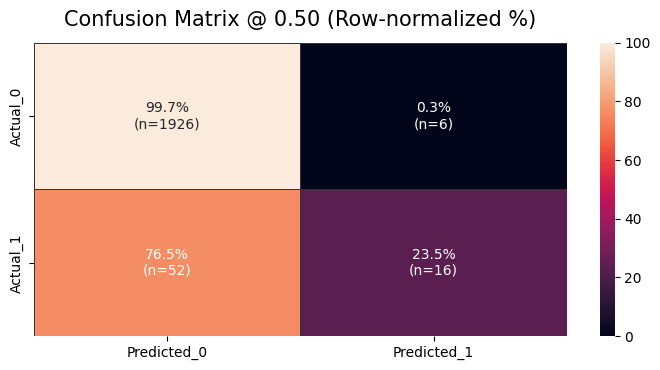


Saved: /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputv2/run_20260202_154242/predictions_lr_valid.csv
Saved: /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputv2/run_20260202_154242/metrics_lr_valid.csv
Saved: /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputv2/run_20260202_154242/models/lr_pipeline.pkl


In [ ]:
# STEP 5 — Fit baseline LR + Validation metrics (HTML) + Confusion Matrix @0.50 (normalized % + counts)

from IPython.display import HTML, display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ---- Fit + predict ----
lr_pipe.fit(X_train, y_train)

valid_proba = lr_pipe.predict_proba(X_valid)[:, 1]
valid_pred_050 = (valid_proba >= 0.50).astype(int)

# ---- Metrics (HTML table) ----
metrics = {
    "model": "LogisticRegression",
    "split": "valid",
    "pr_auc_ap": float(average_precision_score(y_valid, valid_proba)),
    "roc_auc": float(roc_auc_score(y_valid, valid_proba)),
    "precision_0.50": float(precision_score(y_valid, valid_pred_050, zero_division=0)),
    "recall_0.50": float(recall_score(y_valid, valid_pred_050, zero_division=0)),
    "f1_0.50": float(f1_score(y_valid, valid_pred_050, zero_division=0)),
}
metrics_df = pd.DataFrame([metrics])
display(HTML(metrics_df.to_html(index=False)))
print()


# ---- Confusion Matrix @0.50 (row-normalized percentages + counts) ----
cm = confusion_matrix(y_valid, valid_pred_050)  # [[TN, FP],[FN, TP]]

# Row-normalize (per-actual-class) so each row sums to 100%
row_sums = cm.sum(axis=1, keepdims=True)
cm_pct = np.divide(cm, row_sums, out=np.zeros_like(cm, dtype=float), where=row_sums!=0) * 100.0

index = ["Actual_0", "Actual_1"]
cols = ["Predicted_0", "Predicted_1"]

cm_pct_df = pd.DataFrame(cm_pct, index=index, columns=cols)

# Create annotations: "xx.x%\n(n=COUNT)"
annot = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f"{cm_pct[i, j]:.1f}%\n(n={cm[i, j]})"

plt.figure(figsize=(7.2, 3.8))
ax = sns.heatmap(
    cm_pct_df,
    annot=annot,
    fmt="",
    cmap="rocket",
    cbar=True,
    linewidths=0.5,
    linecolor="#333333",
    vmin=0,
    vmax=100
)
ax.set_title("Confusion Matrix @ 0.50 (Row-normalized %)", fontsize=15, pad=12)
ax.set_xlabel("")
ax.set_ylabel("")
plt.tight_layout()
plt.show()
print()


# ---- Save artifacts ----
pred_path = f"{RUN_DIR}/predictions_lr_valid.csv"
met_path  = f"{RUN_DIR}/metrics_lr_valid.csv"
model_path = f"{MODEL_DIR}/lr_pipeline.pkl"

pred_df = pd.DataFrame({
    "y_true": y_valid.values,
    "y_proba": valid_proba,
    "y_pred_0.50": valid_pred_050
}, index=X_valid.index)

pred_df.to_csv(pred_path, index=True)
metrics_df.to_csv(met_path, index=False)

import joblib
joblib.dump(lr_pipe, model_path)

print("Saved:", pred_path)
print("Saved:", met_path)
print("Saved:", model_path)


Step 6 — Fresh model comparison (RF + XGB) on Train→Valid
This still keeps the test set untouched; we only compare using Train (fit) and Valid (evaluate).

In [ ]:
# STEP 6 (revised) — GridSearchCV on Train only, evaluate on Validation
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import average_precision_score
from IPython.display import HTML

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# --- Preprocessors ---
# A) LR preprocessor: OHE + scaling (scaling needed for LR)
preprocess_lr = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), CAT_COLS),
        ("num", StandardScaler(), NUM_COLS),
    ],
    remainder="drop"
)

# B) Tree preprocessor: OHE only; pass numeric through unchanged
preprocess_tree = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), CAT_COLS),
        ("num", "passthrough", NUM_COLS),
    ],
    remainder="drop"
)

# --- Models + grids ---
pipe_lr = Pipeline([("preprocess", preprocess_lr), ("model", LogisticRegression(max_iter=3000, random_state=RANDOM_STATE))])
grid_lr = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__class_weight": ["balanced"]
}

pipe_rf = Pipeline([("preprocess", preprocess_tree), ("model", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))])
grid_rf = {
    "model__n_estimators": [50, 200],
    "model__max_depth": [5, 10, None],
    "model__min_samples_split": [2, 5, 10],
    "model__class_weight": ["balanced"]
}

neg = int((y_train == 0).sum())
pos = int((y_train == 1).sum())
spw = (neg / pos) if pos > 0 else 1.0

pipe_xgb = Pipeline([("preprocess", preprocess_tree), ("model", XGBClassifier(
    random_state=RANDOM_STATE, n_jobs=-1, eval_metric="logloss"
))])
grid_xgb = {
    "model__n_estimators": [50, 200],
    "model__max_depth": [2, 4, 6],
    "model__learning_rate": [0.01, 0.1],
    "model__scale_pos_weight": [spw]
}

searches = [
    ("LogisticRegression", pipe_lr, grid_lr),
    ("RandomForest", pipe_rf, grid_rf),
    ("XGBoost", pipe_xgb, grid_xgb),
]

rows = []
for name, pipe, grid in searches:
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        scoring="average_precision",   # PR-AUC / Average Precision
        cv=cv,
        n_jobs=-1,
        refit=True
    )
    gs.fit(X_train, y_train)

    best = gs.best_estimator_
    valid_proba = best.predict_proba(X_valid)[:, 1]
    valid_ap = average_precision_score(y_valid, valid_proba)

    rows.append({
        "Model": name,
        "CV_PR_AUC_mean": float(gs.best_score_),
        "Valid_PR_AUC": float(valid_ap),
        "Best_Para": str(gs.best_params_),
        "Remark": ""  # fill manually later
    })

results = pd.DataFrame(rows).sort_values("Valid_PR_AUC", ascending=False)
display(results)
HTML(results.to_html(index=False))
print()


# Save
out_path = f"{RUN_DIR}/gridsearch_results_valid_pr_auc.csv"
results.to_csv(out_path, index=False)
print("Saved:", out_path)


,Model,CV_PR_AUC_mean,Valid_PR_AUC,Best_Para,Remark
2,XGBoost,0.779219,0.775618,"{'model__learning_rate': 0.1, 'model__max_dept...",
1,RandomForest,0.725017,0.701209,"{'model__class_weight': 'balanced', 'model__ma...",
0,LogisticRegression,0.443065,0.410073,"{'model__C': 0.1, 'model__class_weight': 'bala...",



Saved: /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputv2/run_20260202_154242/gridsearch_results_valid_pr_auc.csv


Run the below cell <font color=red>**ONLY**</font> when Step 6 is done to add "Remarks".

In [ ]:
# Fill Remark + re-save (optional)
results_path = f"{RUN_DIR}/gridsearch_results_valid_pr_auc.csv"
results_df = pd.read_csv(results_path)

remarks = {
    "XGBoost": "Selected (highest Valid PR-AUC). Next: threshold tuning + risk bands on Validation.",
    "RandomForest": "Runner-up; nonlinear baseline.",
    "LogisticRegression": "Baseline; interpretable but weaker PR-AUC."
}

results_df["Remark"] = results_df["Model"].map(remarks).fillna("")
results_df.to_csv(results_path, index=False)

from IPython.display import HTML, display
display(HTML(results_df.to_html(index=False)))
print()
print("Updated:", results_path)


Model,CV_PR_AUC_mean,Valid_PR_AUC,Best_Para,Remark
XGBoost,0.779219,0.775618,"{'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 200, 'model__scale_pos_weight': 28.55665024630542}",Selected (highest Valid PR-AUC). Next: threshold tuning + risk bands on Validation.
RandomForest,0.725017,0.701209,"{'model__class_weight': 'balanced', 'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}",Runner-up; nonlinear baseline.
LogisticRegression,0.443065,0.410073,"{'model__C': 0.1, 'model__class_weight': 'balanced'}",Baseline; interpretable but weaker PR-AUC.



Updated: /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputv2/run_20260202_154242/gridsearch_results_valid_pr_auc.csv


Step 7 - Bar Chart Visual

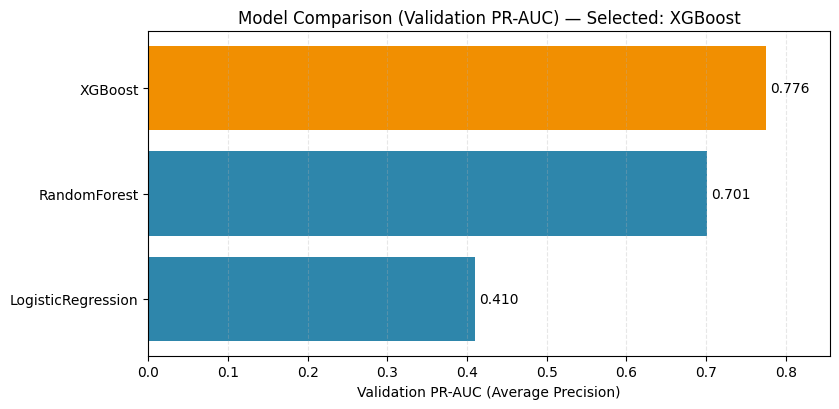


Saved: /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputv2/run_20260202_154242/slide7_valid_pr_auc_bar.png


In [ ]:
# STEP 7 — Bar chart for Slide 7 (Validation PR-AUC by model)

import os
import pandas as pd
import matplotlib.pyplot as plt

# Load Step 6 results
results_path = f"{RUN_DIR}/gridsearch_results_valid_pr_auc.csv"
assert os.path.exists(results_path), f"Missing: {results_path}. Run Step 6 first."

df = pd.read_csv(results_path)

# Sort for plotting
df = df.sort_values("Valid_PR_AUC", ascending=True).copy()

# Pick winner (highest Valid_PR_AUC)
winner = df.loc[df["Valid_PR_AUC"].idxmax(), "Model"]

# Colors: highlight winner
colors = ["#2E86AB" if m != winner else "#F18F01" for m in df["Model"]]

plt.figure(figsize=(8.5, 4.2))
bars = plt.barh(df["Model"], df["Valid_PR_AUC"], color=colors)

# Labels on bars
for b in bars:
    w = b.get_width()
    plt.text(w + 0.005, b.get_y() + b.get_height()/2, f"{w:.3f}", va="center", fontsize=10)

plt.xlim(0, max(df["Valid_PR_AUC"].max() + 0.08, 0.5))
plt.xlabel("Validation PR-AUC (Average Precision)")
plt.title(f"Model Comparison (Validation PR-AUC) — Selected: {winner}")
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()

# Save figure for Slide 7
fig_path = f"{RUN_DIR}/slide7_valid_pr_auc_bar.png"
plt.savefig(fig_path, dpi=200, bbox_inches="tight")
plt.show()
print()

print("Saved:", fig_path)


Run below code to get the **XGBoost Validation predictions**.

Codes can be run stand-alone.


In [4]:
# XGBoost: Train on Train split -> Predict on Validation split -> Save predictions_xgb_valid.csv
import os
import joblib
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBClassifier

from google.colab import drive
drive.mount("/content/drive")

# ---- Paths (edit RUN_DIR to your run folder) ----
RUN_DIR = "/content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputv2/run_20260202_154242"
MODEL_DIR = f"{RUN_DIR}/models"
os.makedirs(MODEL_DIR, exist_ok=True)

SPLIT_PATH = f"{RUN_DIR}/split_indices_60_20_20_NEW.csv"

# Try a few likely dataset locations; keep the one that exists
candidate_data_paths = [
    "/content/drive/MyDrive/Colab Notebooks/ADALL Project/Ai4i.csv",
    "/content/drive/MyDrive/Colab Notebooks/ADALL Project/Data/Ai4i.csv",
    "/content/drive/MyDrive/Colab Notebooks/ADALL Project/data/Ai4i.csv",
]
DATA_PATH = next((p for p in candidate_data_paths if os.path.exists(p)), None)
if DATA_PATH is None:
    raise FileNotFoundError(f"Could not find Ai4i.csv. Checked: {candidate_data_paths}")

# ---- Load data + locked leakage drops ----
df = pd.read_csv(DATA_PATH)

leakage_cols = ["UDI", "Product ID", "TWF", "HDF", "PWF", "OSF", "RNF"]
target_col = "Machine failure"

df = df.drop(columns=leakage_cols)

# ---- Load split indices ----
split_df = pd.read_csv(SPLIT_PATH)  # columns: index, split
train_idx = split_df.loc[split_df["split"].eq("train"), "index"].values
valid_idx = split_df.loc[split_df["split"].eq("valid"), "index"].values

X_train = df.loc[train_idx].drop(columns=[target_col])
y_train = df.loc[train_idx, target_col].astype(int)

X_valid = df.loc[valid_idx].drop(columns=[target_col])
y_valid = df.loc[valid_idx, target_col].astype(int)

# ---- Preprocess: OneHotEncode Type; pass numeric through ----
cat_cols = ["Type"]
num_cols = [c for c in X_train.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)

# ---- Best params from your gridsearch table ----
xgb_clf = XGBClassifier(
    learning_rate=0.1,
    max_depth=6,
    n_estimators=200,
    scale_pos_weight=28.55665024630542,
    subsample=1.0,
    colsample_bytree=1.0,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgb_pipe = Pipeline(steps=[("preprocess", preprocess), ("model", xgb_clf)])

# ---- Fit on Train only ----
xgb_pipe.fit(X_train, y_train)

# ---- Predict on Validation ----
valid_proba = xgb_pipe.predict_proba(X_valid)[:, 1]
valid_pred_050 = (valid_proba >= 0.50).astype(int)

# ---- Save artifacts ----
pred_path = f"{RUN_DIR}/predictions_xgb_valid.csv"
model_path = f"{MODEL_DIR}/xgb_pipeline.pkl"

pred_df = pd.DataFrame(
    {
        "y_true": y_valid.values,
        "y_proba": valid_proba,
        "y_pred_0.50": valid_pred_050,
    },
    index=valid_idx
)
pred_df.to_csv(pred_path, index=True)
joblib.dump(xgb_pipe, model_path)

print("Saved:", pred_path)
print()
print("Saved:", model_path)
print()
print("Validation rows:", len(pred_df), "| Positives:", int(pred_df["y_true"].sum()))
print("y_proba min/max:", float(pred_df["y_proba"].min()), float(pred_df["y_proba"].max()))
print(pred_df.head(5))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved: /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputv2/run_20260202_154242/predictions_xgb_valid.csv

Saved: /content/drive/MyDrive/Colab Notebooks/ADALL Project/Outputv2/run_20260202_154242/models/xgb_pipeline.pkl

Validation rows: 2000 | Positives: 68
y_proba min/max: 9.670996405475307e-06 0.999985933303833
    y_true   y_proba  y_pred_0.50
4        0  0.000119            0
5        0  0.000043            0
7        0  0.000042            0
13       0  0.000212            0
16       0  0.000858            0


### Place Holder